# Bounding box detection - Racoon data


## Data files
- images_racoon.rar: contain images of racoons
- train_labels.cv: contains coordinates for bounding box for every image

### Import the necessary libraries

In [1]:
import csv
import cv2
import numpy as np
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.utils import Sequence
from PIL import Image
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.layers import Conv2D, Reshape
from tensorflow.keras.backend import epsilon

### Change directory

In [2]:
DATASET_FOLDER = './images/'

### Load the training data from train.csv file

In [3]:
df = pd.read_csv('train_labels (1).csv')
df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-17.jpg,259,194,raccoon,95,60,167,118
1,raccoon-11.jpg,660,432,raccoon,3,1,461,431
2,raccoon-63.jpg,600,400,raccoon,74,107,280,290
3,raccoon-63.jpg,600,400,raccoon,227,93,403,298
4,raccoon-60.jpg,273,185,raccoon,58,33,197,127


### Print the shape of the train dataset

In [4]:
df.shape

(173, 8)

### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [5]:
IMAGE_SIZE = 128
BATCH_SIZE = 32

### With the help of csv.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

In [49]:
class DataSequence(Sequence):
    def __init__(self):
        self.paths = []
        with open('train_labels (1).csv', 'r') as file:
            self.coords = np.zeros((df.shape[0], 4))
            reader = csv.reader(file)
            next(reader)
            for index, row in enumerate(reader):
                p, w, h, class_, xmin, ymin, xmax, ymax = row
                self.coords[index, 0] = int(xmin) * IMAGE_SIZE / int(w)
                self.coords[index, 1] = int(ymin) * IMAGE_SIZE / int(h)
                self.coords[index, 2] = (int(xmax) - int(ymax)) * IMAGE_SIZE / int(w)
                self.coords[index, 3] = (int(ymax) - int(ymin)) * IMAGE_SIZE / int(h)
                self.paths.append(p)
    
    def __getitem__(self, idx):
        batch_paths = self.paths[idx * BATCH_SIZE: (idx + 1) * BATCH_SIZE] # Image path
        batch_coords = self.coords[idx * BATCH_SIZE: (idx + 1) * BATCH_SIZE] # Image coords
        
        batch_images = np.zeros((len(batch_paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
        for i,f in enumerate(batch_paths):
            for j, r in enumerate(f): # Parse row with seven entities
                #print(i)
                if((j!= 0) & (j!=3)):
                    row[j] = int(r)
            img = Image.open('./images/'+f)
            img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
            img = img.convert('RGB')
            batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))
            img.close()
        
        return batch_images, batch_coords
    
    def __len__(self):
        return math.ceil(len(self.paths) / BATCH_SIZE)
# import csv
# with open('train_labels (1).csv','r') as csvfile:
#     paths = []
#     coords = np.zeros((sum(1 for line in csvfile) - 1, 4))
#     spamreader = csv.reader(csvfile, delimiter=',')
#     csvfile.seek(0)
#     next(spamreader, None)
#     for i,row in enumerate(spamreader):
#         #print(row)
#         for j, r in enumerate(row): # Parse row with seven entities
#             #print(i)
#             if((j!= 0) & (j!=3)):
#                 row[j] = int(r)
            
#         #print(row)      
#         path, width, height, class_, xmin, ymin, xmax, ymax = row
#         paths.append(path)
#         #print(i)
#         coords[i,0] = xmin * IMAGE_SIZE / width
#         coords[i,1] = ymin * IMAGE_SIZE / height
#         coords[i,2] = xmax * IMAGE_SIZE / width # Normalize bounding box by image size
#         coords[i,3] = ymax * IMAGE_SIZE / height
# batch_images = np.zeros((len(paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
# for i, f in enumerate(paths):
#     img = Image.open('./images/'+f)
#     img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
#     img = img.convert('RGB')
#     batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))

### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [50]:
from tensorflow.keras.applications.mobilenet import MobileNet

def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_SIZE,IMAGE_SIZE, 3), include_top=False, alpha=1.0)
    
    for layer in model.layers:
        layer.trainable = trainable
    
    x = model.layers[-1].output
    x = Conv2D(4, kernel_size=4, name='coords')(x)
    x = Reshape((4,))(x)
    
    return Model(inputs=model.input, outputs=x)


### Define a custom loss function IoU which calculates Intersection Over Union

In [51]:
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_func(loss, [y_true, y_pred], tf.float32)
    return iou

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [52]:
tf.keras.backend.clear_session()
model = create_model(trainable=False)
model.summary()

train_datagen = DataSequence()
model.compile(loss='mse', optimizer='adam', metrics=[IoU])
checkpoint = ModelCheckpoint("model-{val_iou:.2f}.h5", verbose=1, save_best_only=True,
                              save_weights_only=True, mode="max", period=1) # Checkpoint best validation model
stop = EarlyStopping(monitor="val_iou", patience=10, mode="max") # Stop early, if the validation error deteriorates
reduce_lr = ReduceLROnPlateau(monitor="val_iou", factor=0.2, patience=10, min_lr=1e-7, verbose=1, mode="max")



Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128   

In [55]:
model.fit(generator=train_datagen, 
                    epochs=20, 
                    batch_size=32,
                    use_multiprocessing=True,
                    shuffle=True, 
                    verbose=1)

Epoch 1/20


ValueError: invalid literal for int() with base 10: 'a'

### Pick a test image from the given data

In [45]:
filename = './images/raccoon-10.jpg'
unscaled = cv2.imread(filename)

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [46]:
image_height, image_width, _ = unscaled.shape
image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE)) # Rescaled image to run the network
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

### Predict the coordinates of the bounding box for the given test image

In [47]:
region = model.predict(x=np.array([feat_scaled]))[0] # Predict the BBox
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

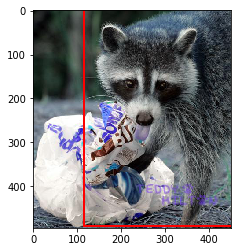

In [48]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np


# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()